In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context='notebook', style='white', font_scale=1.6, color_codes=True)
plt.style.use('dark_background')


# Sparse Regression

Here we compare models of fully Bayesian sparse linear regression with pairwais interaction terms. We start by introducing hierarchical shrinkage priors in the form of regularised horseshoe distribution [1], next we introduce QR decomposition and illustrate its utility in the presence of highly corelated predictors (elements of the design matrix) [2], and finally introduce the sparse kernel interaction model (SKIM) proposed in [3]. SKIM is particularly suitable for situations with many feature dimensions (large D) but not too many datapoints (small N).

We will consider a quadratic regressor of the form:

\begin{equation}
    \begin{split}
        f\left( X, \pmb{\beta} \right) &= \alpha + \sum_i \beta_i X_i + \sum_{i<j} \beta_{ij} X_i X_j \\
        y &\sim p \left(y | f\left( X, \pmb{\beta} \right), \theta  \right)
    \end{split}
\end{equation}

In the case of normal likelihood, that is:

$$ p \left(y | f\left( X, \pmb{\beta} \right), \theta  \right) = \mathcal{N} \left(y; f(X, \pmb{\beta}), \sigma^2 \right) $$

we are dealing with a linear regression problem. In the case of Bernoulli likelihood, that is:

$$ p \left(y | f\left( X, \pmb{\beta} \right), \theta  \right) = s \left( f(X, \pmb{\beta}) \right)^y \left(1 - s \left( f(X, \pmb{\beta}) \right) \right)^{1-y}; \:\: \text{for } y \in \{ 0, 1 \} $$

we are dealing with a logistic regression problem.

**References:**

    1. Piironen, Juho, and Aki Vehtari (2017),  
        "Sparsity information and regularization in the horseshoe and other shrinkage priors." 
        Electronic Journal of Statistics 11.2 : 5018-5051.
        
    2. https://mc-stan.org/users/documentation/case-studies/qr_regression.html

    3. Raj Agrawal, Jonathan H. Huggins, Brian Trippe, Tamara Broderick (2019), 
       "The kernel interaction trick: Fast bayesian discovery of pairwise interactions in high dimensions." 
       International Conference on Machine Learning. PMLR.

In [2]:
import itertools
import numpyro
numpyro.set_platform("cpu")
num_chains=1
numpyro.set_host_device_count(num_chains)
numpyro.enable_validation(True)

import numpy as np

import jax
from jax import vmap, nn
import jax.numpy as jnp
import jax.random as random
# from jax.scipy.linalg import cho_factor, cho_solve, solve_triangular
# from scipy.cluster.vq import kmeans2

import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, init_to_feasible
from numpyro.infer.reparam import TransformReparam
from numpyro.distributions.transforms import Transform, AffineTransform, ComposeTransform

In [3]:
# Create artificial regression dataset where only S out of P feature
# dimensions contain signal. If pairwise=True then there is a single 
# pairwise interaction between the first and second dimensions.
def get_data(X, S=2, sigma=1., pairwise=False, logistic=False):
    N, D = X.shape
    assert S < D and D > 1 and S > 0

    np.random.seed(101)

    # generate S coefficients with non-negligible magnitude
    W = 1.0 + 2.0 * np.random.rand(S)
    if pairwise:
        # generate data using the S coefficients and a single pairwise interaction
        f = np.sum(X[:, 0:S] * W, axis=-1) + X[:, 0] * X[:, 1]
    else:
        f = np.sum(X[:, 0:S] * W, axis=-1)
        
    if logistic:
        Y = random.bernoulli(random.PRNGKey(0), p=nn.sigmoid(f))
        return X, Y, W, 1.0
    else:
        Y = f + sigma * np.random.randn(N)
        Y -= jnp.mean(Y)
        Y_std = jnp.std(Y)       
        return X, Y/Y_std, W / Y_std, 1.0 / Y_std

In [4]:
import numpyro.distributions as dist

S = 5
D = 50
N = 200

X = np.random.randn(N, D)
X, Y1, expected_thetas1, expected_pairwise = get_data(X, S=S, pairwise=False, logistic=False)

print(expected_thetas1)

[0.47421387 0.49953374 0.24656644 0.31330708 0.55300623]


# Bayesian linear regression

Given a normal likelihood 
$$ p \left(y | f\left( X, \pmb{\beta} \right), \theta  \right) = \mathcal{N} \left(y; f(X, \pmb{\beta}), \sigma^2 \right) $$

and the following prior over regression coefficients
$$ p(\pmb{\beta}) = \mathcal{N}_D\left(\pmb{\beta}; 0, \tau^2 \pmb{\Lambda} \right); \:\: \text{for } \pmb{\Lambda} = diag(\lambda_1^2, \ldots, \lambda_D^2)$$

The posterior for the coefficients $\pmb{\beta}$ given the (hyper)paramters and data $\mathcal{D} = \left( \pmb{X}, \pmb{y} \right)$ is
\begin{equation}
    \begin{split}
        p\left(\pmb{\beta}|\pmb{\Lambda}, \tau, \sigma, \mathcal{D} \right) &= \mathcal{N}\left(\pmb{\beta}; \bar{\pmb{\beta}}, \pmb{\Sigma} \right) \\
        \hat{\pmb{\beta}} &= \left( \pmb{X}^T \pmb{X} \right)^{-1} \pmb{X}^T \pmb{y} \\
        \bar{\pmb{\beta}} &= \tau^2 \pmb{\Lambda} \left( \tau^2 \pmb{\Lambda} + \sigma^2 \left(\pmb{X}^T \pmb{X} \right)^{-1} \right)^{-1} \hat{\pmb{\beta}}\\
        \pmb{\Sigma} &= \left( \frac{1}{\tau^2} \pmb{\Lambda}^{-1} + \frac{1}{\sigma^2} \pmb{X}^T \pmb{X} \right)^{-1} 
    \end{split}
\end{equation}

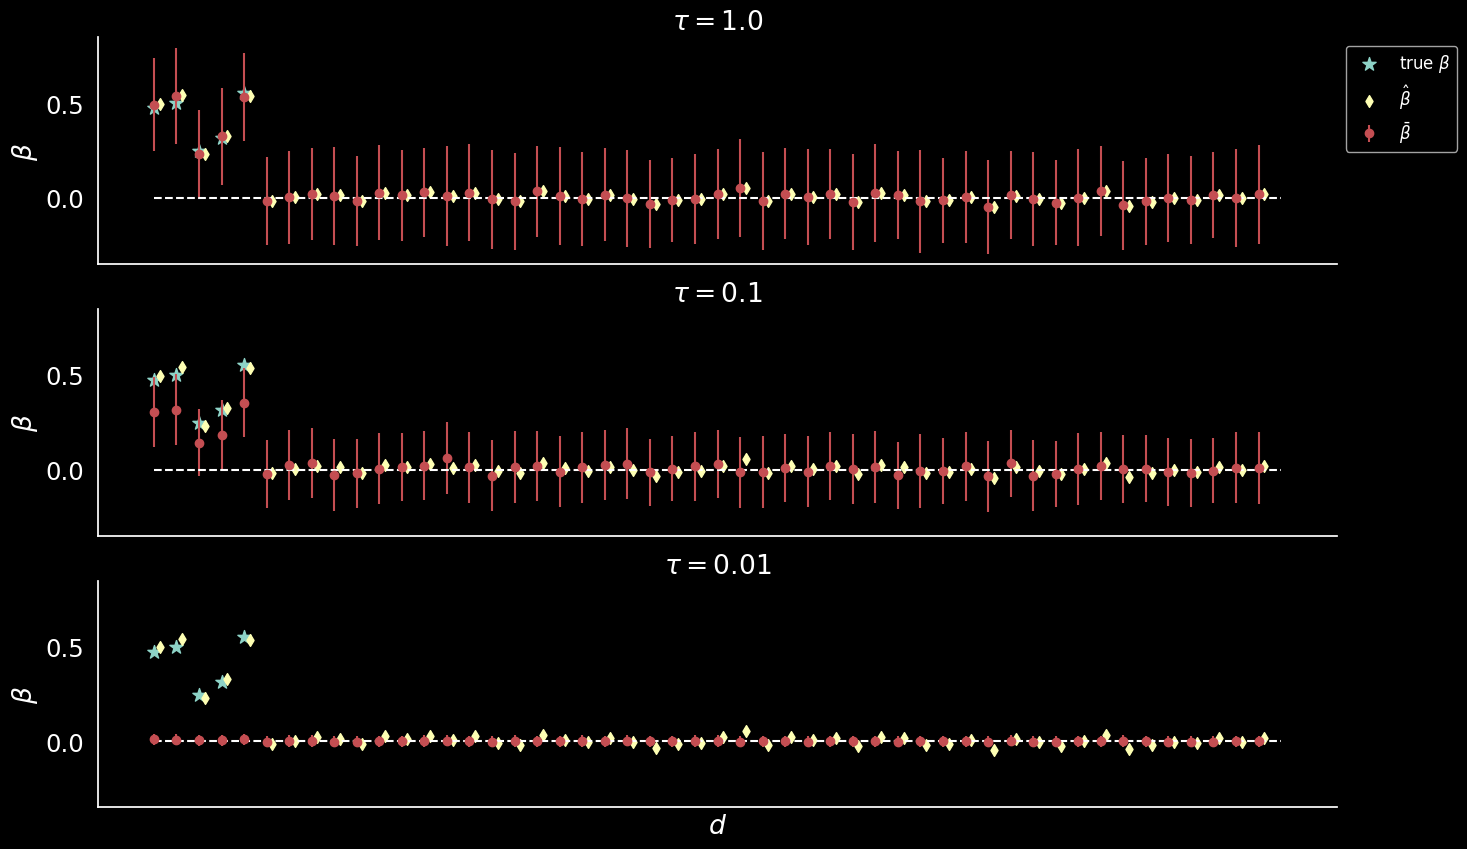

In [5]:
def blr(X, y, tau=1, sigma=1):
    # bayesian linear regression
    N, D = X.shape
    Lambda = np.eye(D)
    S = X.T @ X
    hat_beta = np.linalg.inv(S) @ X.T @ y
    bar_beta = tau**2 * Lambda @ np.linalg.inv(tau**2*Lambda + sigma**2 * np.linalg.inv(S)) @ hat_beta 
    Sigma = np.linalg.inv( np.linalg.inv(Lambda)/tau**2 + S/sigma**2)
    return bar_beta, hat_beta, Sigma

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True, sharey=True)
tau = [1., .1, .01]
for i in range(3):
    bar_beta, hat_beta, Sigma = blr(X, Y1, tau=tau[i])
    axes[i].errorbar(np.arange(1, D + 1), bar_beta, yerr=3*np.sqrt(np.diag(Sigma)), color='r', marker='o', ls='', label=r'$\bar{\beta}$')
    axes[i].scatter(np.arange(1, S+1), expected_thetas1, marker='*', s=100, label=r'true $\beta$')
    axes[i].scatter(np.arange(1, D + 1) + .25, hat_beta, marker='d', label=r'$\hat{\beta}$')
    axes[i].hlines(0, 1, D + 1, 'w', ls='--')
    axes[i].set_ylabel(r'$\beta$')
    axes[i].set_title(r'$\tau={}$'.format(tau[i]))

axes[-1].set_xticks([])
axes[-1].set_xlabel(r'$d$')
axes[0].legend(bbox_to_anchor=(1,1), loc="upper left", fontsize=12)
sns.despine()

# fig.savefig('blr_example.png', transparent=True, bbox_inches='tight', dpi=300)

In [6]:
from jax import nn, lax
from numpyro.distributions import constraints

class QRTransform(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector

    def __init__(self, R, R_inv):
        if jnp.ndim(R) != 2:
            raise ValueError(
                "Only support 2-dimensional R matrix. "
            )
        self.R = R
        self.R_inv = R_inv

    def __call__(self, x):
        return jnp.squeeze(
            jnp.matmul(self.R, x[..., jnp.newaxis]), axis=-1
        )

    def _inverse(self, y):
        return jnp.squeeze(
            jnp.matmul(self.R_inv, y[..., jnp.newaxis]), axis=-1
        )

    def log_abs_det_jacobian(self, x, y, intermediates=None):
        return jnp.broadcast_to(
            jnp.log(jnp.diagonal(self.R, axis1=-2, axis2=-1)).sum(-1),
            jnp.shape(x)[:-1],
        )

    def forward_shape(self, shape):
        if len(shape) < 1:
            raise ValueError("Too few dimensions on input")
        return lax.broadcast_shapes(shape, self.R.shape[:-1])

    def inverse_shape(self, shape):
        if len(shape) < 1:
            raise ValueError("Too few dimensions on input")
        return lax.broadcast_shapes(shape, self.R.shape[:-1])

class BayesRegression(object):
    def __init__(self, rng_key, X, tau=1., p0=None, fixed_lam=True, with_qr=False, reg_type='linear'):
        self.N, self.D = X.shape
        self.X = X
        self.rng_key = rng_key
        self.tau = tau
        self.fixed_lam = fixed_lam
        self.with_qr = with_qr
        self.p0 = p0
        self.type = reg_type # type of the rergression problem
        
        if self.with_qr:
            # use QR decomposition
            self.Q, self.R = jnp.linalg.qr(X)
            self.R_inv = jnp.linalg.inv(self.R)
        
    def model(self, obs=None):
        sigma_sqr = numpyro.sample('sigma^2', dist.InverseGamma(2., 2.))
        sigma = numpyro.deterministic('sigma', jnp.sqrt(sigma_sqr))
        
        if self.p0 is None:
            tau = self.tau * sigma
        else:
            tau0 = self.p0 * sigma / ((self.D - self.p0) * jnp.sqrt(self.N))
            tau = numpyro.sample('tau', dist.HalfCauchy(tau0))
            
        if self.fixed_lam:
            lam = numpyro.deterministic('lam', jnp.ones(self.D))
        else:
            lam = numpyro.sample('lam', dist.HalfCauchy(1.).expand([self.D]).to_event(1))
            
        if self.with_qr:
            rt = QRTransform(self.R, self.R_inv)
            aff = AffineTransform(0., tau * lam)
            ct = ComposeTransform([aff, rt])
            with handlers.reparam(config={"theta": TransformReparam()}):
                theta = numpyro.sample(
                    'theta', 
                    dist.TransformedDistribution(dist.Normal(0., 1.).expand([D]).to_event(1), ct)
                )

            numpyro.deterministic('beta', rt.inv(theta))
            tmp = self.Q.dot(theta)

        else:
            aff = AffineTransform(0., tau * lam)
            with handlers.reparam(config={"beta": TransformReparam()}):
                beta = numpyro.sample(
                    'beta', 
                    dist.TransformedDistribution(dist.Normal(0., 1.).expand([self.D]).to_event(1), aff)
                )
            tmp = self.X.dot(beta)

        alpha = numpyro.sample('alpha', dist.Normal(0., 10.))
        mu = numpyro.deterministic('mu', alpha + tmp)
        
        with numpyro.plate('data', self.N):
            if self.type == 'linear':
                numpyro.sample('obs', dist.Normal(mu, sigma), obs=obs)
            elif self.type == 'logistic':
                numpyro.sample('obs', dist.Bernoulli(logits=mu), obs=obs)
            elif self.type == 'possion':
                numpyro.sampel('obs', dist.Poisson(jnp.exp(mu)), obs=obs)
    
    def fit(self, data, num_samples=1000, warmup_steps=1000, num_chains=1, summary=True, progress_bar=True):
        self.rng_key, _rng_key = random.split(self.rng_key)

        nuts_kernel = NUTS(self.model, init_strategy=init_to_feasible)
        mcmc = MCMC(nuts_kernel, 
                    num_warmup=warmup_steps, 
                    num_samples=num_samples, 
                    num_chains=num_chains,
                    chain_method='vectorized',
                    progress_bar=progress_bar)
        mcmc.run(_rng_key, obs=data)

        if summary:
            mcmc.print_summary()

        samples = mcmc.get_samples(group_by_chain=False)
        self.mcmc = mcmc
        self.samples = samples

        return samples

sample: 100%|██████████| 2000/2000 [00:02<00:00, 998.77it/s, 7 steps of size 5.17e-01. acc. prob=0.87] 


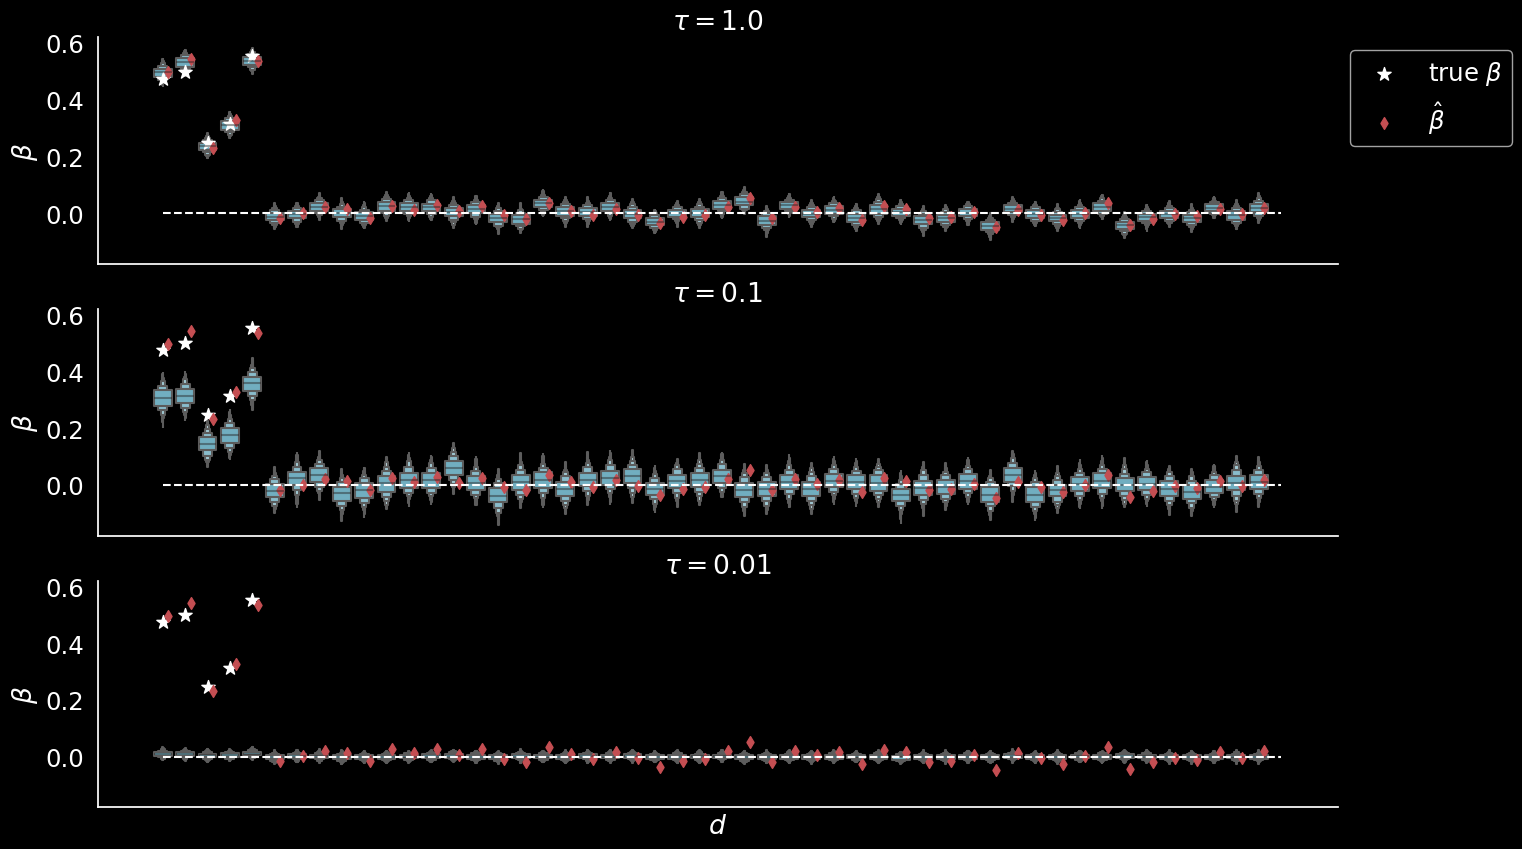

In [7]:
rng_key = random.PRNGKey(101)
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True, sharey=True)
tau = [1., .1, .01]
for i in range(3):
    rng_key, _rng_key = random.split(rng_key)
    BLR = BayesRegression(rng_key, jnp.array(X), tau=tau[i], fixed_lam=True)
    samples = BLR.fit(jnp.array(Y1), summary=False, num_chains=num_chains)
    
    sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[i], showfliers=False)
    axes[i].scatter(np.arange(S), expected_thetas1, color='w', marker='*', s=100, label=r'true $\beta$')
    axes[i].scatter(np.arange(D) + .25, hat_beta, color='r', marker='d', label=r'$\hat{\beta}$')
    axes[i].hlines(0, 0, D, 'w', ls='--')
    axes[i].set_ylabel(r'$\beta$')
    axes[i].set_title(r'$\tau={}$'.format(tau[i]))

axes[-1].set_xticks([])
axes[-1].set_xlabel(r'$d$')
axes[0].legend(bbox_to_anchor=(1,1), loc="upper left")
sns.despine()

# fig.savefig('example_sampling.png', transparent=True, bbox_inches='tight', dpi=300)

# Horseshoe prior

The horseshoe prior consist of a half-cauchy prior distribution for individual $\lambda_d$ parameters

$$ \lambda_d \sim C^+(0, 1) = \begin{cases} \frac{2}{\pi} \frac{1}{1 + \lambda_d^2}, &\text{for } \lambda_d \geq 0 \\ 0 & \text{otherwise}\end{cases}$$

The origin of the name is related to the corresponding shape of the shrinkage factor $\kappa_d$ under the given prior over $\lambda_d$. 
The shrinkage factor depends on $\lambda_d$ as follows:

$$ \bar{\beta}_d = (1 - \kappa_d) \hat{\beta}_d$$
$$ \kappa_d = \frac{1}{1 + N \tau^2 \lambda_d^2 s_d^2}$$
$$ Var(\pmb{x}_d) = s_d^2$$

Then the corresponding prior over shrinkage factor has the following functional form

$$ p(\kappa_d) = \frac{1}{\pi} \frac{a_d}{(a_d^2-1)\kappa_d + 1} \frac{1}{\sqrt{\kappa_d}\sqrt{1 - \kappa_d}}$$
$$ a_d = N \sigma^{-1} \tau s_d$$
When $a_d=1$ we have a prior over $\kappa_d$ in the shape of a horseshoe. 

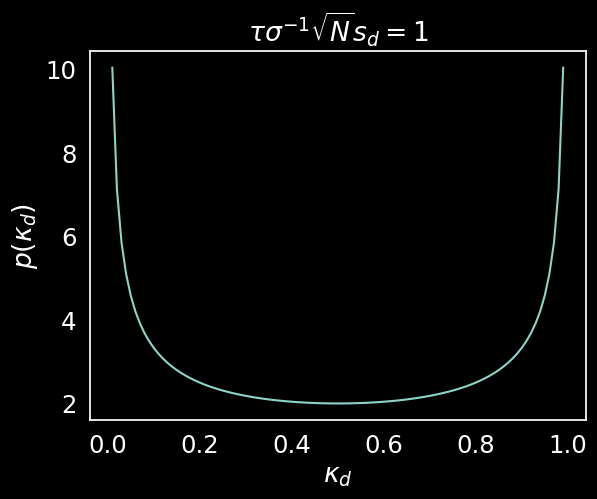

In [8]:
kappa = np.arange(0.01, 1, 0.01)
plt.plot(kappa, 1/(np.sqrt(kappa)*np.sqrt(1 - kappa)))
plt.ylabel(r'$p(\kappa_d)$');
plt.xlabel(r'$\kappa_d$');
plt.title(r'$\tau \sigma^{-1} \sqrt{N} s_d = 1$');
# plt.savefig('horseshoe.png', transparent=True, bbox_inches='tight', dpi=300)

In what follows we illustrate the effect of horseshoe prior on the results for different values of global shrinkage parameter $\tau$

sample: 100%|██████████| 2000/2000 [00:03<00:00, 589.64it/s, 127 steps of size 3.10e-02. acc. prob=0.85] 


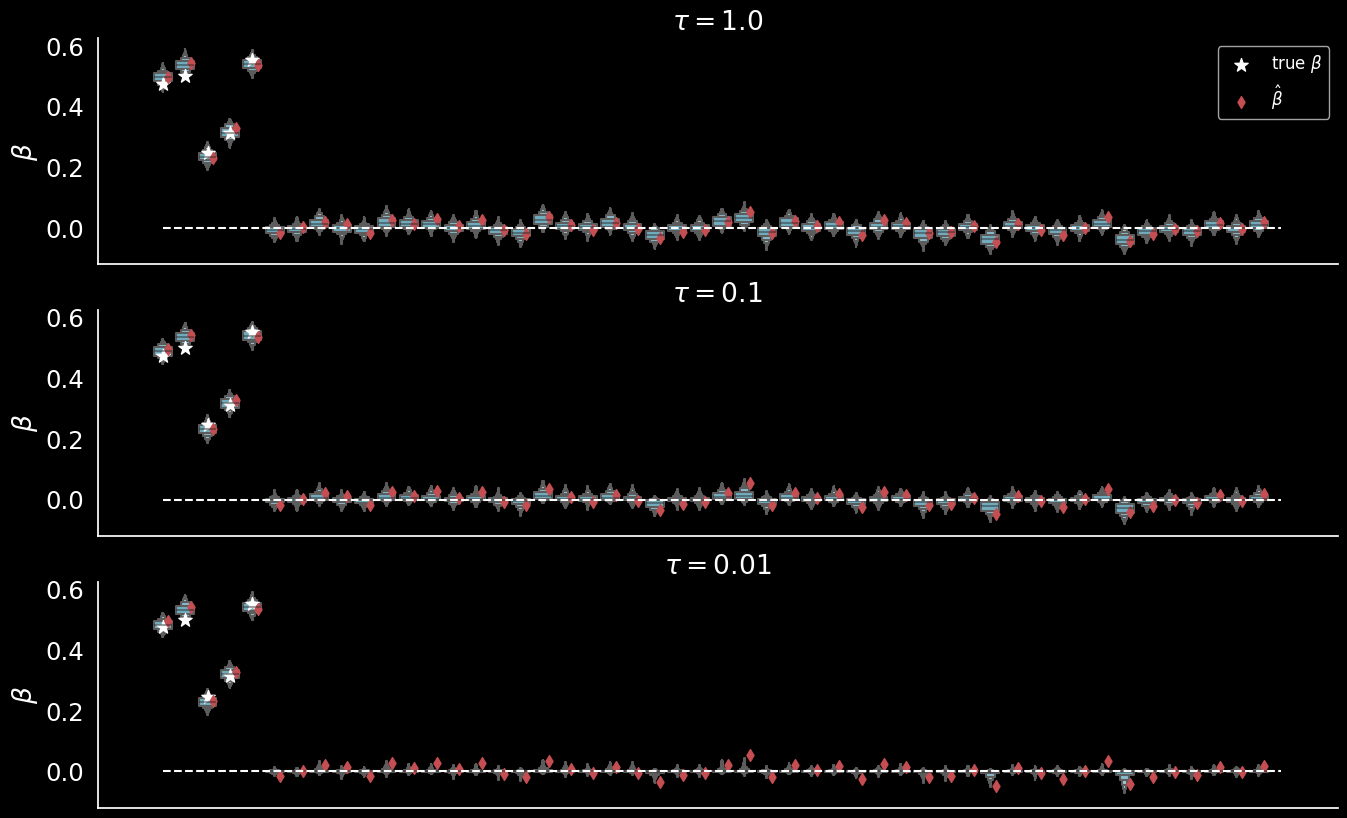

In [9]:
rng_key = random.PRNGKey(101)
fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True, sharey=True)
tau = [1., .1, .01]
for i in range(3):
    rng_key, _rng_key = random.split(rng_key)
    BLR = BayesRegression(rng_key, jnp.array(X), tau=tau[i], fixed_lam=False)
    samples = BLR.fit(jnp.array(Y1), summary=False, num_chains=num_chains)
    
    sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[i], showfliers=False)
    axes[i].scatter(np.arange(S), expected_thetas1, color='w', marker='*', s=100, label=r'true $\beta$')
    axes[i].scatter(np.arange(D) + .25, hat_beta, color='r', marker='d', label=r'$\hat{\beta}$')
    axes[i].hlines(0, 0, D, 'w', ls='--')
    axes[i].set_ylabel(r'$\beta$')
    axes[i].set_title(r'$\tau={}$'.format(tau[i]))

axes[-1].set_xticks([])
axes[0].legend(loc="upper right", fontsize=12)
sns.despine()
# fig.savefig('example_sampling2.png', transparent=True, bbox_inches='tight', dpi=300)

Finally we can also introduce a prior over $\tau$ in the form of half-cauchy distribution
$$ \tau \sim C^{+}(0, \tau_0^2) $$
This type of hierachical prior is known as the horseshoe+ (horseshoe +) prior. Importantly, $\tau_0$ can be selected in the way to constrain the global shrinkage to an initial guess about the number of non-zero coefficients. We will denote this quantity as $p_0$ and the corresponding value of $\tau_0$ is then obtained as 
$$ \tau_0 = \frac{p_0}{D - p_0} \frac{\sigma}{\sqrt{N}}$$
where $N$ denotes number of data points and $D$ number of coefficeints. The derivation and justification for the above relation is described in detail in Piironen et al. 2017.  

sample: 100%|██████████| 2000/2000 [00:04<00:00, 459.39it/s, 255 steps of size 1.43e-02. acc. prob=0.94]


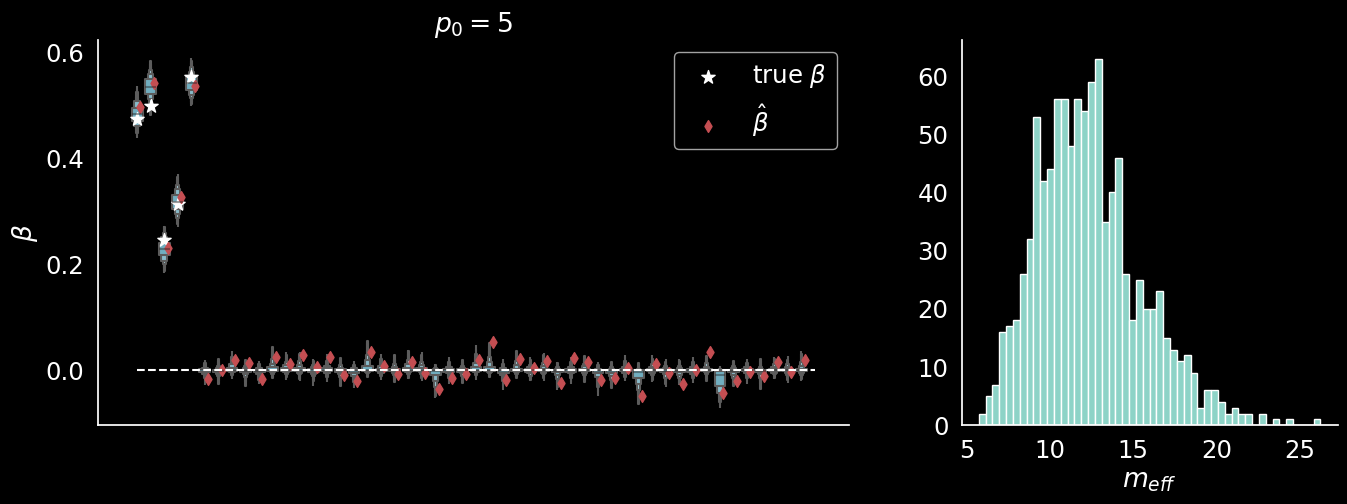

In [10]:
def m_eff(D, N, p0, s_sqr, sigma, tau, lam):
    kappa = 1/(1 + N * jnp.expand_dims(tau, -1)**2 * lam**2 * s_sqr / jnp.expand_dims(sigma, -1) ** 2)
    return jnp.sum( 1 - kappa, -1)

rng_key = random.PRNGKey(101)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.2})
p0 = 5
rng_key, _rng_key = random.split(rng_key)
BLR = BayesRegression(rng_key, jnp.array(X), fixed_lam=False, p0=p0)
samples = BLR.fit(jnp.array(Y1), summary=False, num_chains=num_chains)

sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[0], showfliers=False)
axes[0].scatter(np.arange(S), expected_thetas1, color='w', marker='*', s=100, label=r'true $\beta$')
axes[0].scatter(np.arange(D) + .25, hat_beta, color='r', marker='d', label=r'$\hat{\beta}$')

axes[0].hlines(0, 0, D, 'w', ls='--')
axes[0].set_ylabel(r'$\beta$')
axes[0].set_title(r'$p_0={}$'.format(p0))
axes[0].set_xticks([])
axes[0].legend(loc="upper right")

m_e = m_eff(D, N, p0, np.var(X, 0, ddof=1), samples['sigma'], samples['tau'], samples['lam'])
axes[1].hist(np.array(m_e), bins=50)
axes[1].set_xlabel(r'$m_{eff}$')

sns.despine()
# fig.savefig('full_model.png', transparent=True, bbox_inches='tight', dpi=300)

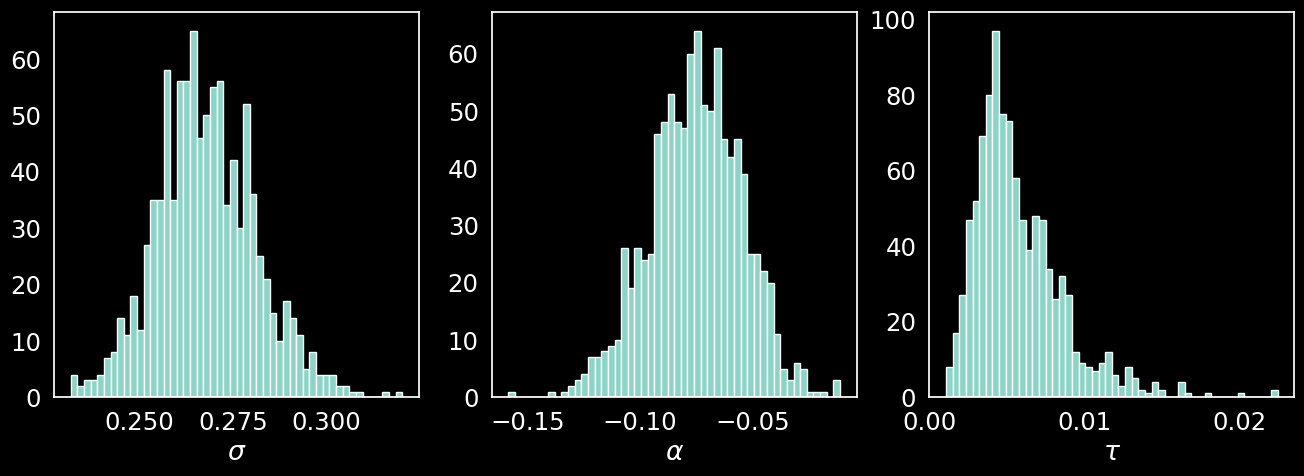

In [11]:
# posterior distribution for other model parameters
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].hist(np.array(samples['sigma']), bins=50);
axes[0].set_xlabel(r'$\sigma$')
axes[1].hist(np.array(samples['alpha']), bins=50);
axes[1].set_xlabel(r'$\alpha$')
axes[2].hist(np.array(samples['tau']), bins=50);
axes[2].set_xlabel(r'$\tau$');
# fig.savefig('other_parameters.png', transparent=True, bbox_inches='tight', dpi=300)

sample: 100%|██████████| 2000/2000 [00:05<00:00, 353.18it/s, 255 steps of size 1.32e-02. acc. prob=0.91]


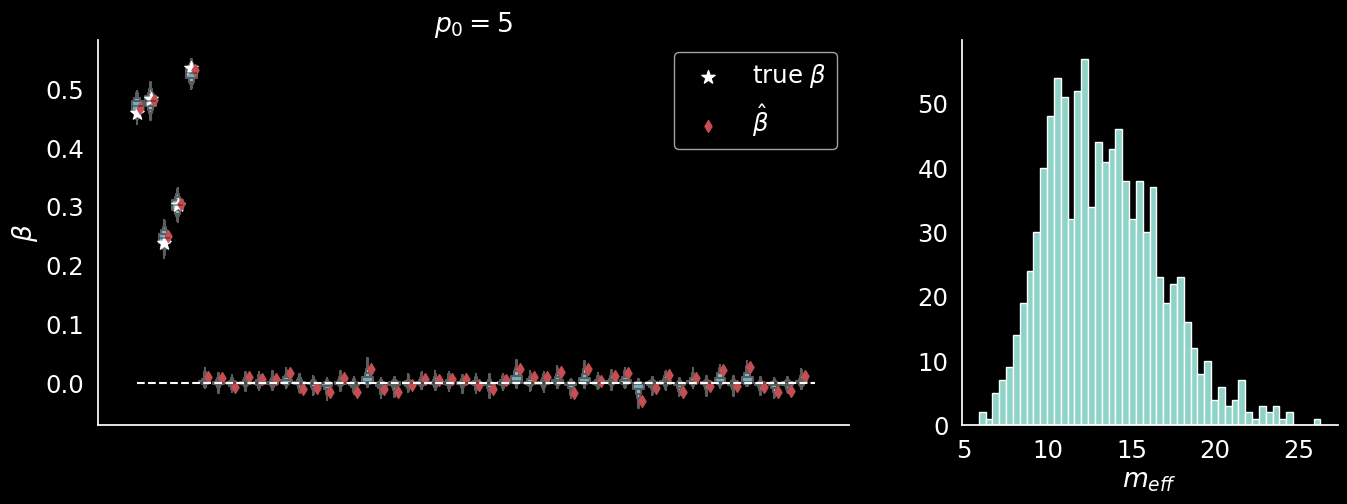

In [12]:
N = 400
X = np.random.randn(N, D)
X, Y1, expected_thetas1, expected_pairwise = get_data(X, S=S, pairwise=False, logistic=False)

_, hat_beta, _ = blr(X, Y1)

rng_key = random.PRNGKey(101)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.2})
p0 = 5
rng_key, _rng_key = random.split(rng_key)
BLR = BayesRegression(rng_key, jnp.array(X), fixed_lam=False, p0=p0)
samples = BLR.fit(jnp.array(Y1), summary=False, num_chains=num_chains)

sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[0], showfliers=False)
axes[0].scatter(np.arange(S), expected_thetas1, color='w', marker='*', s=100, label=r'true $\beta$')
axes[0].scatter(np.arange(D) + .25, hat_beta, color='r', marker='d', label=r'$\hat{\beta}$')

axes[0].hlines(0, 0, D, 'w', ls='--')
axes[0].set_ylabel(r'$\beta$')
axes[0].set_title(r'$p_0={}$'.format(p0))
axes[0].set_xticks([])
axes[0].legend(loc="upper right")

m_e = m_eff(D, N, p0, np.var(X, 0, ddof=1), samples['sigma'], samples['tau'], samples['lam'])
axes[1].hist(np.array(m_e), bins=50)
axes[1].set_xlabel(r'$m_{eff}$')

sns.despine()

sample: 100%|██████████| 2000/2000 [00:09<00:00, 205.31it/s, 511 steps of size 8.71e-03. acc. prob=0.92]


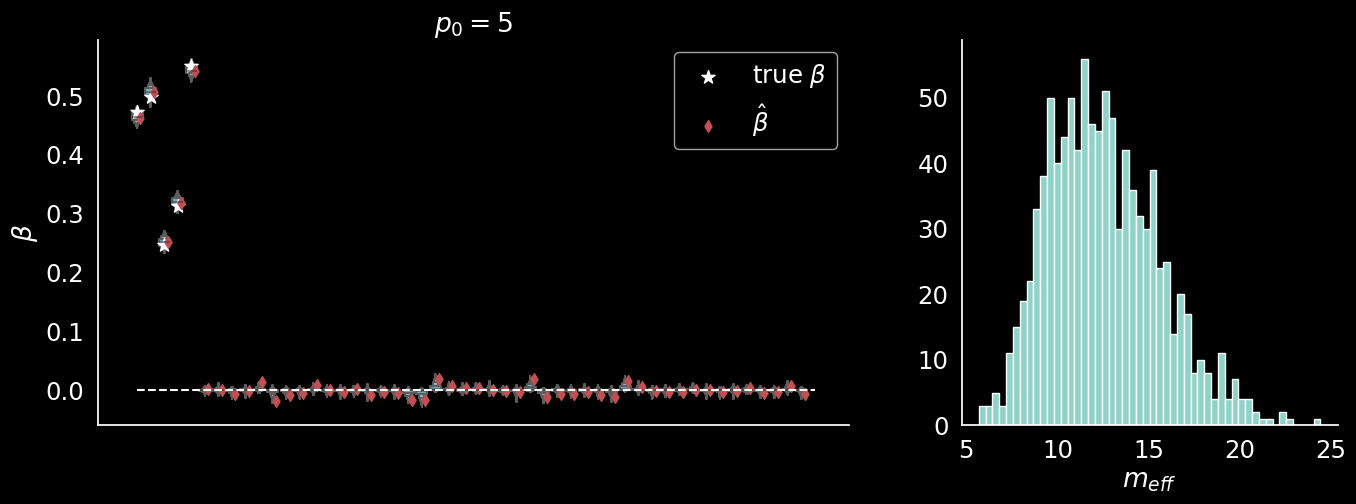

In [13]:
N = 800
X = np.random.randn(N, D)
X, Y1, expected_thetas1, expected_pairwise = get_data(X, S=S, pairwise=False, logistic=False)
_, hat_beta, _ = blr(X, Y1)

rng_key = random.PRNGKey(101)
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.2})
p0 = 5
rng_key, _rng_key = random.split(rng_key)
BLR = BayesRegression(rng_key, jnp.array(X), fixed_lam=False, p0=p0)
samples = BLR.fit(jnp.array(Y1), summary=False, num_chains=num_chains)

sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[0], showfliers=False)
axes[0].scatter(np.arange(S), expected_thetas1, color='w', marker='*', s=100, label=r'true $\beta$')
axes[0].scatter(np.arange(D) + .25, hat_beta, color='r', marker='d', label=r'$\hat{\beta}$')

axes[0].hlines(0, 0, D, 'w', ls='--')
axes[0].set_ylabel(r'$\beta$')
axes[0].set_title(r'$p_0={}$'.format(p0))
axes[0].set_xticks([])
axes[0].legend(loc="upper right")

m_e = m_eff(D, N, p0, np.var(X, 0, ddof=1), samples['sigma'], samples['tau'], samples['lam'])
axes[1].hist(np.array(m_e), bins=50)
axes[1].set_xlabel(r'$m_{eff}$')

sns.despine()

# Correlated predictors
In practice, the predictors (the elements of a desing matrix $\pmb{X}$) will often be correlated. Here we illustrate how the results change under these conditions.

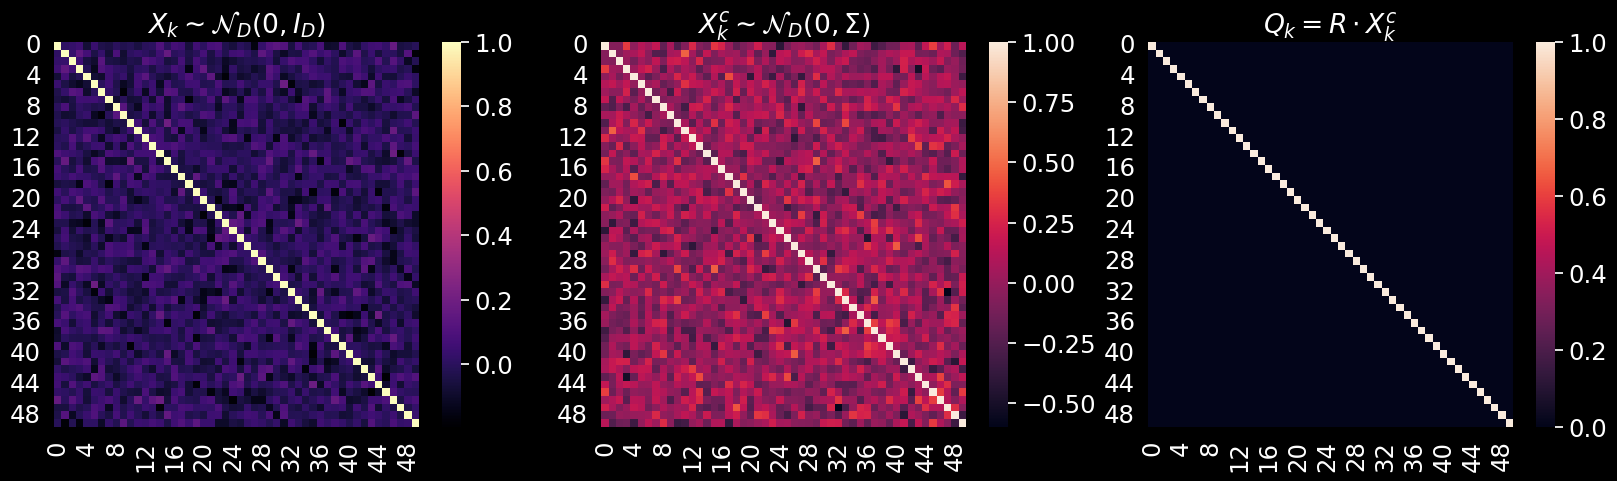

In [14]:
L = dist.LKJCholesky(D, 1.).sample(random.PRNGKey(1))

N = 200
X = np.random.randn(N, D)
X_corr = X @ L.T
X_corr = (X_corr - X_corr.mean(0))/X_corr.std(0)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(np.corrcoef(X.T), ax=axes[0], cmap='magma')
axes[0].set_title(r'$X_k \sim \mathcal{N}_D(0, I_D)$')
sns.heatmap(np.corrcoef(X_corr.T), ax=axes[1])
axes[1].set_title(r'$X_k^c \sim \mathcal{N}_D(0, \Sigma)$')
Q, R = np.linalg.qr(X_corr)
sns.heatmap(np.corrcoef(Q.T), ax=axes[2])
axes[2].set_title(r'$Q_k = R \cdot X_k^c$');
# fig.savefig('cm.png', transparent=True, bbox_inches='tight', dpi=300)

sample: 100%|██████████| 2000/2000 [00:03<00:00, 598.59it/s, 255 steps of size 8.69e-03. acc. prob=0.88] 


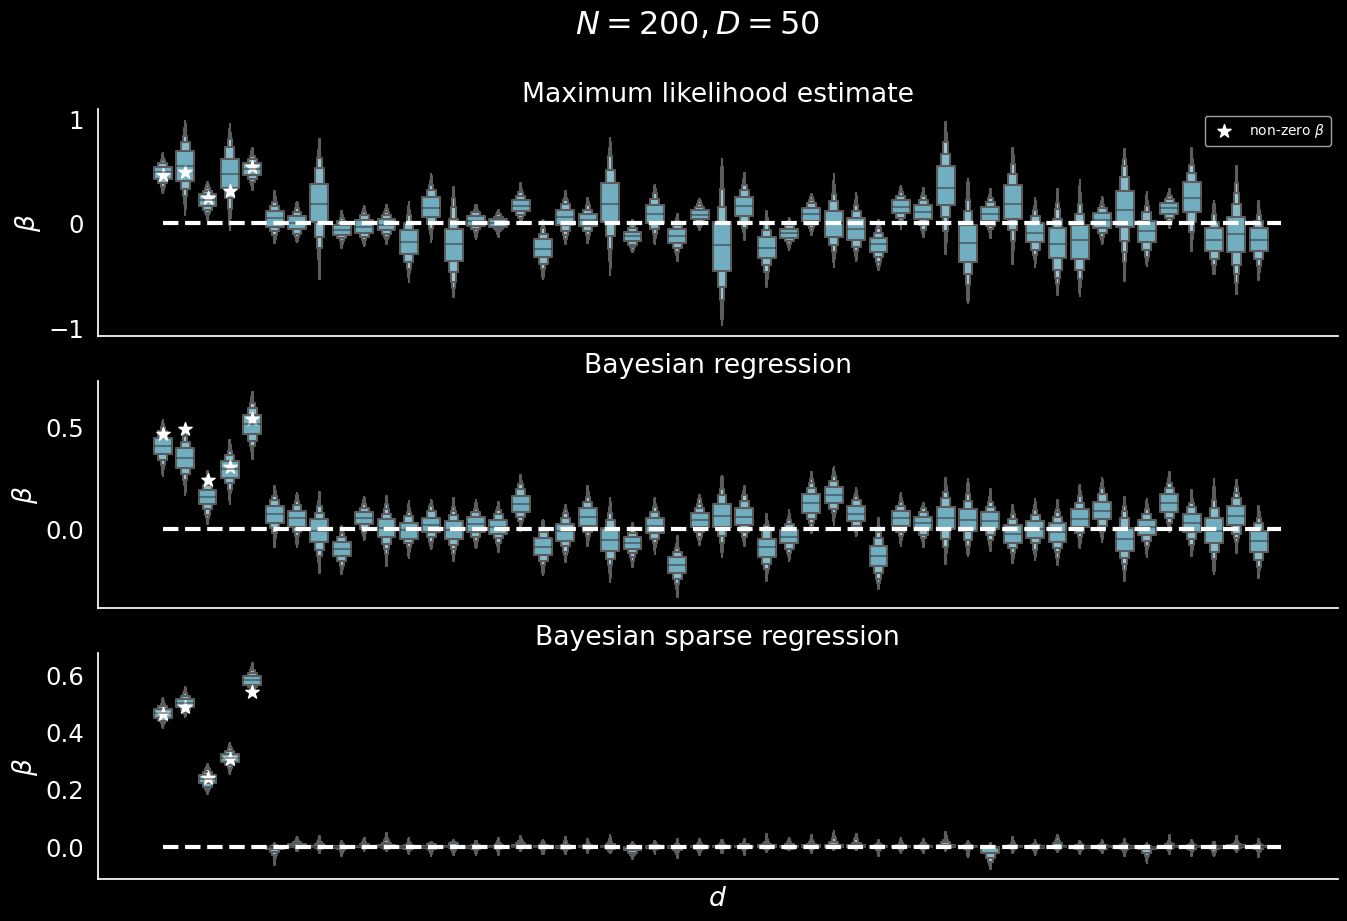

In [15]:
rng_key = random.PRNGKey(101)

N = 200
X = np.random.randn(N, D)
X_corr = X @ L.T
X_corr = (X_corr - X_corr.mean(0))/X_corr.std(0)
X_corr, Y2, expected_thetas2, expected_pairwise = get_data(X_corr, S=S, pairwise=False, logistic=False)

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
p0 = 5
rng_key, _rng_key = random.split(rng_key)
BLR = BayesRegression(rng_key, jnp.array(X_corr), fixed_lam=False, p0=5, with_qr=True)
samples = BLR.fit(jnp.array(Y2), summary=False, num_chains=num_chains)

rng_key, _rng_key = random.split(rng_key)
BLR = BayesRegression(rng_key, jnp.array(X_corr), fixed_lam=True, p0=None)
samples2 = BLR.fit(jnp.array(Y2), summary=False, num_chains=num_chains)

rng_key, _rng_key = random.split(rng_key)
BLR = BayesRegression(rng_key, jnp.array(X_corr), tau=1e3, fixed_lam=True, p0=None)
samples3 = BLR.fit(jnp.array(Y2), summary=False, num_chains=num_chains)

for i, beta in enumerate([samples3['beta'], samples2['beta'], samples['beta']]):
    sns.boxenplot(data=np.array(beta), color='c', ax=axes[i], showfliers=False)
    axes[i].scatter(np.arange(S), expected_thetas2, color='w', marker='*', s=100, label=r'non-zero $\beta$')
    axes[i].hlines(0, 0, D, 'w', ls='--', lw=3)
    axes[i].set_ylabel(r'$\beta$')

axes[-1].set_xticks([])
axes[-1].set_xlabel(r'$d$')
axes[0].legend(loc="upper right", fontsize=10)
fig.suptitle(r'$N={}, D={}$'.format(N, D))
axes[0].set_title('Maximum likelihood estimate')
axes[1].set_title('Bayesian regression')
axes[2].set_title('Bayesian sparse regression')
sns.despine()
# fig.savefig('comparison.png', transparent=True, bbox_inches='tight', dpi=300)

# Logistic regression
The same structure of sparse hierarchical priors can be applied to other regression problems, like logistic regression or poisson regression. 

In [16]:
S = 5
D = 50
N = 1000

X = np.random.randn(N, D)
X, Y1_log, expected_thetas1_log, expected_pairwise = get_data(X, S=S, pairwise=False, logistic=True)

L = dist.LKJCholesky(D, 1.).sample(random.PRNGKey(1))
X_corr = X @ L
X_corr = (X_corr - X_corr.mean(0))/X_corr.std(0)
X_corr, Y2_log, expected_thetas2_log, expected_pairwise = get_data(X_corr, S=S, pairwise=False, logistic=True)

sample: 100%|██████████| 2000/2000 [00:06<00:00, 325.76it/s, 127 steps of size 2.95e-02. acc. prob=0.90]


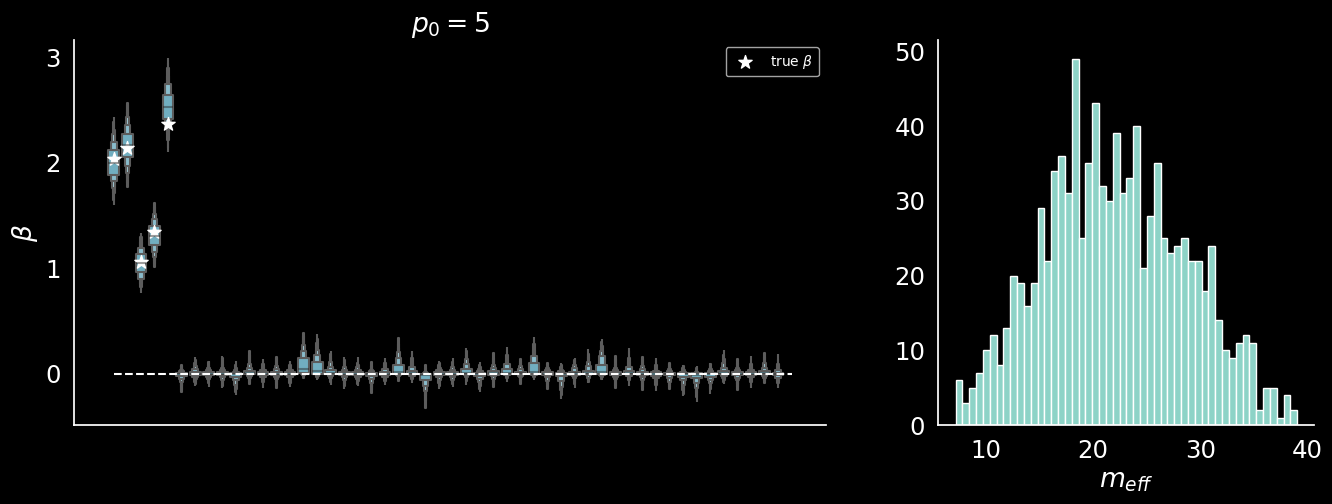

In [17]:
# independent predictors
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.2})
p0 = 5
rng_key, _rng_key = random.split(rng_key)
LQR_reg = BayesRegression(rng_key, jnp.array(X), fixed_lam=False, p0=5, with_qr=True, reg_type='logistic')
samples = LQR_reg.fit(jnp.array(Y1_log), summary=False, num_chains=num_chains)

sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[0], showfliers=False)
axes[0].scatter(np.arange(S), expected_thetas1_log, color='w', marker='*', s=100, label=r'true $\beta$')
axes[0].hlines(0, 0, D, 'w', ls='--')

axes[0].set_ylabel(r'$\beta$')
axes[0].set_title(r'$p_0={}$'.format(p0))
axes[0].set_xticks([])
axes[0].legend(loc="upper right", fontsize=10)

m_e = m_eff(D, N, p0, np.var(X, 0, ddof=1), samples['sigma'], samples['tau'], samples['lam'])
axes[1].hist(np.array(m_e), bins=50)
axes[1].set_xlabel(r'$m_{eff}$')

sns.despine()

sample: 100%|██████████| 2000/2000 [00:05<00:00, 349.43it/s, 127 steps of size 4.19e-02. acc. prob=0.79]


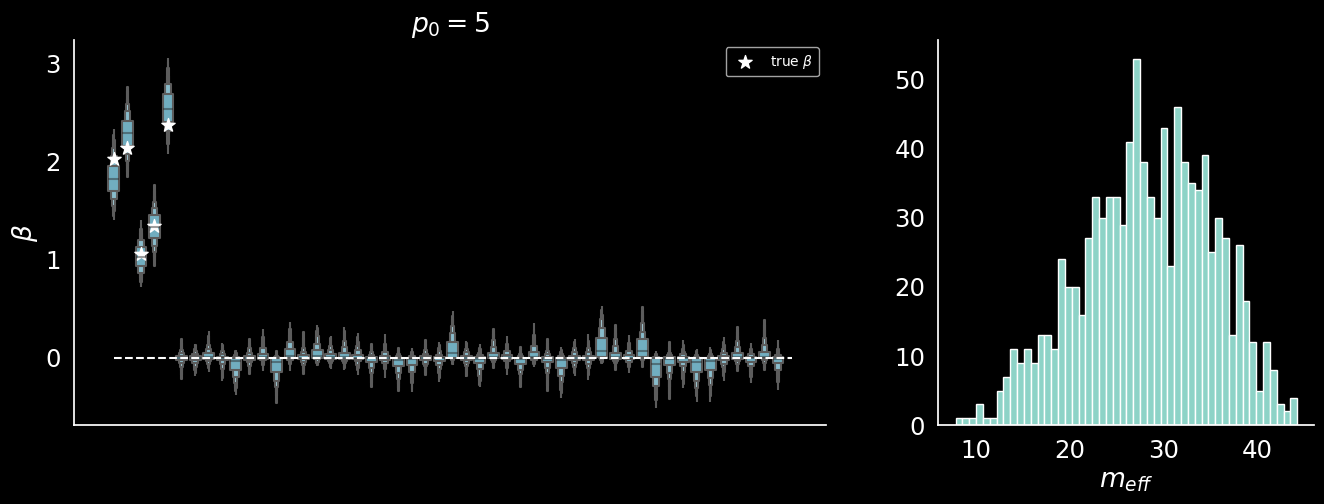

In [18]:
# correlated predictors
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [2, 1], 'wspace': 0.2})
p0 = 5
rng_key, _rng_key = random.split(rng_key)
LQR_reg = BayesRegression(rng_key, jnp.array(X_corr), fixed_lam=False, p0=5, with_qr=True, reg_type='logistic')
samples = LQR_reg.fit(jnp.array(Y2_log), summary=False, num_chains=num_chains)

sns.boxenplot(data=np.array(samples['beta']), color='c', ax=axes[0], showfliers=False)
axes[0].scatter(np.arange(S), expected_thetas2_log, color='w', marker='*', s=100, label=r'true $\beta$')
axes[0].hlines(0, 0, D, 'w', ls='--')

axes[0].set_ylabel(r'$\beta$')
axes[0].set_title(r'$p_0={}$'.format(p0))
axes[0].set_xticks([])
axes[0].legend(loc="upper right", fontsize=10)

m_e = m_eff(D, N, p0, np.var(X, 0, ddof=1), samples['sigma'], samples['tau'], samples['lam'])
axes[1].hist(np.array(m_e), bins=50)
axes[1].set_xlabel(r'$m_{eff}$')

sns.despine()

# The kernel interaction trick: 
### Fast bayesian discovery of pairwise interactions in high dimensions.

Often encountered (linear) regression problem is contribution of pairwise interactions of predictors $x_i x_j$ to the measured responses $y$. The structural hierachical prior for the generative model with the interaction terms and corresponding coefficients $\beta_{ij}$ can be expressed as follows
\begin{equation}
    \begin{split}
        \lambda_i & \sim C^+(0, 1) \\
        \tau_1 & \sim C^+(0, \tau_0^2) \\
        \tau_2 &\sim C^+(0, \tau_1^2) \\
        \beta_i & \sim \mathcal{N}\left(0, \tau_1 \lambda_i \right) \\
        \beta_{ij} &\sim \mathcal{N}\left(0, \tau_2 \lambda_i \lambda_j \right) \\
        \alpha &\sim \mathcal{N}(0, c^2)
    \end{split}
\end{equation}

Importantly, direct esimation of pairwise interactions is computationally chalanging for large number of predictors $D$. One can achieve substantial runtime and memory improvments by marginalising out the regresssion coefficients from the generative model and expressing the regression problem as a gaussian process model. This approach is called Sparse Kernel Interaction Model (SKIM) introduced by Agrawal et al. 2019. The modifiied generative model is expressed as 

\begin{equation}
    \begin{split}
        \lambda_i & \sim C^+(0, 1) \\
        \tau_1 & \sim C^+(0, \tau_0^2) \\
        \tau_2 &\sim C^+(0, \tau_1^2) \\
         y &\sim \mathcal{N}\left( 0, \pmb{K} \right)
    \end{split}
\end{equation}
where the kernel matrix is obtained as a sum of polynomial kernels 
$$ k(x, \tilde{x}) = \frac{\tau_2^2}{2} \left(1 + x\cdot\tilde{x}\right)^2 - \frac{\tau_2^2}{2} \left( 1 + x^2 \cdot \tilde{x}^2 \right) + (\tau_1^2 - \tau_2^2) x \cdot \tilde{x} + c^2$$
$$ k(x, \tilde{x}) = \frac{\tau_2^2}{2} \left( (x \cdot \tilde{x})^2 - x^2 \cdot \tilde{x}^2 \right) + \tau_1^2 x \cdot \tilde{x} + c^2$$
where 
$$ x_i, \tilde{x}_j = \lambda_i X_i, \lambda_j X_j $$

In what follows we will test the SKIM on data generated with independent and correlated predictors. The code we use here is a copy of examples provided by the Numpyro's documentation [page](https://num.pyro.ai/en/stable/examples/sparse_regression.html).

In [19]:
S = 5
D = 50
N = 200

X = np.random.randn(N, D)
X, Y1_pair, expected_thetas1_pair, expected_pairwise1 = get_data(X, S=S, pairwise=True, logistic=False)

L = dist.LKJCholesky(D, 1.).sample(random.PRNGKey(1))
X_corr = X @ L
X_corr = (X_corr - X_corr.mean(0))/X_corr.std(0)
X_corr, Y2_pair, expected_thetas2_pair, expected_pairwise2 = get_data(X_corr, S=S, pairwise=True, logistic=False)

In [28]:
def dot(X, Z):
    return jnp.dot(X, Z[..., None])[..., 0]

# The kernel that corresponds to a quadratic regressor.
def kernel(X, Z, tau1, tau2, c, jitter=1e-4):
    tau1sq = jnp.square(tau1)
    tau2sq = jnp.square(tau2)
    K1 = dot(X, Z)
    K2 = dot(jnp.square(X), jnp.square(Z))
    k1 = 0.5 * tau2sq * jnp.square(1.0 + K1)
    k2 = - 0.5 * tau2sq * K2
    k3 = (tau1sq - tau2sq) * K1
    k4 = jnp.square(c) - 0.5 * tau2sq
    if X.shape == Z.shape:
        k4 += jitter * jnp.eye(X.shape[0])
    return k1 + k2 + k3 + k4

def skim(X, Y=None, p0=5, c=10.):
    N, D = X.shape
    
    sigma_sqr = numpyro.sample('sigma^2', dist.InverseGamma(2., 2.))
    sigma = numpyro.deterministic('sigma', jnp.sqrt(sigma_sqr))
    
    tau0 = sigma * (p0/jnp.sqrt(N)) / (D - p0)
    tau1 = numpyro.sample('tau1', dist.HalfCauchy(tau0))
    tau2 = numpyro.sample('tau2', dist.HalfCauchy(tau1))
    
    lam = numpyro.sample('lam', dist.HalfCauchy(1.).expand([D]).to_event(1))
    
    # compute kernel
    lX = lam * X
    k = kernel(lX, lX, tau1, tau2, c) + sigma_sqr * jnp.eye(N)
    assert k.shape == (N, N)
    
    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), scale_tril=jnp.linalg.cholesky(k)),
        obs=Y,
    )

        
# Compute the mean and variance of coefficient theta_i (where i = dimension) for a
# MCMC sample of the kernel hyperparameters (eta1, xisq, ...).
# Compare to theorem 5.1 in reference [1].
def compute_singleton_mean_variance(X, Y, dimension, lam, tau1, tau2, sigma, c):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((2, P))
    probe = probe.at[:, dimension].set(jnp.array([1.0, -1.0]))

    kX = lam * X
    kprobe = lam * probe

    k_xx = kernel(kX, kX, tau1, tau2, c) + sigma ** 2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, tau1, tau2, c)
    k_prbprb = kernel(kprobe, kprobe, tau1, tau2, c)

    vec = jnp.array([0.50, -0.50])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


# Compute the mean and variance of coefficient theta_ij for a MCMC sample of the
# kernel hyperparameters (eta1, xisq, ...). Compare to theorem 5.1 in reference [1].
def compute_pairwise_mean_variance(X, Y, dim1, dim2, lam, tau1, tau2, sigma, c):
    P, N = X.shape[1], X.shape[0]

    probe = jnp.zeros((4, P))
    probe = probe.at[:, dim1].set( jnp.array([1.0, 1.0, -1.0, -1.0]) )
    probe = probe.at[:, dim2].set( jnp.array([1.0, -1.0, 1.0, -1.0]) )

    kX = lam * X
    kprobe = lam * probe

    k_xx = kernel(kX, kX, tau1, tau2, c) + sigma ** 2 * jnp.eye(N)
    k_xx_inv = jnp.linalg.inv(k_xx)
    k_probeX = kernel(kprobe, kX, tau1, tau2, c)
    k_prbprb = kernel(kprobe, kprobe, tau1, tau2, c)

    vec = jnp.array([0.25, -0.25, -0.25, 0.25])
    mu = jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, Y))
    mu = jnp.dot(mu, vec)

    var = k_prbprb - jnp.matmul(k_probeX, jnp.matmul(k_xx_inv, jnp.transpose(k_probeX)))
    var = jnp.matmul(var, vec)
    var = jnp.dot(var, vec)

    return mu, var


# Sample coefficients theta from the posterior for a given MCMC sample.
# The first P returned values are {theta_1, theta_2, ...., theta_P}, while
# the remaining values are {theta_ij} for i,j in the list `active_dims`,
# sorted so that i < j.
from jax.scipy.linalg import cho_factor, cho_solve, solve_triangular
def sample_theta_space(X, Y, active_dims, lam, tau1, tau2, sigma, c):
    P, N, M = X.shape[1], X.shape[0], len(active_dims)
    # the total number of coefficients we return
    num_coefficients = P + M * (M - 1) // 2

    probe = jnp.zeros((2 * P + 2 * M * (M - 1), P))
    vec = jnp.zeros((num_coefficients, 2 * P + 2 * M * (M - 1)))
    start1 = 0
    start2 = 0

    for dim in range(P):
        probe = probe.at[start1 : start1 + 2, dim].set(jnp.array([1.0, -1.0]))
        vec = vec.at[start2, start1 : start1 + 2].set(jnp.array([0.5, -0.5]))

        start1 += 2
        start2 += 1

    for dim1 in active_dims:
        for dim2 in active_dims:
            if dim1 >= dim2:
                continue
            probe = probe.at[start1 : start1 + 4, dim1].set( jnp.array([1.0, 1.0, -1.0, -1.0]) )
            probe = probe.at[start1 : start1 + 4, dim2].set( jnp.array([1.0, -1.0, 1.0, -1.0]) )
            vec = vec.at[start2, start1 : start1 + 4].set( jnp.array([0.25, -0.25, -0.25, 0.25]) )
            start1 += 4
            start2 += 1

    kX = lam * X
    kprobe = lam * probe

    k_xx = kernel(kX, kX, tau1, tau2, c) + sigma ** 2 * jnp.eye(N)
    L = cho_factor(k_xx, lower=True)[0]
    k_probeX = kernel(kprobe, kX, tau1, tau2, c)
    k_prbprb = kernel(kprobe, kprobe, tau1, tau2, c)

    mu = jnp.matmul(k_probeX, cho_solve((L, True), Y))
    mu = jnp.sum(mu * vec, axis=-1)

    Linv_k_probeX = solve_triangular(L, jnp.transpose(k_probeX), lower=True)
    covar = k_prbprb - jnp.matmul(jnp.transpose(Linv_k_probeX), Linv_k_probeX)
    covar = jnp.matmul(vec, jnp.matmul(covar, jnp.transpose(vec)))

    # sample from N(mu, covar)
    L = jnp.linalg.cholesky(covar)
    sample = mu + jnp.matmul(L, np.random.randn(num_coefficients))

    return sample

# Get the mean and variance of a gaussian mixture
def gaussian_mixture_stats(mus, variances):
    mean_mu = jnp.mean(mus)
    mean_var = jnp.mean(variances) + jnp.mean(jnp.square(mus)) - jnp.square(mean_mu)
    return mean_mu, mean_var


# Helper function for analyzing the posterior statistics for coefficient theta_i
def analyze_dimension(samples, X, Y, dimension, c=10.):
    vmap_args = (
        samples["lam"],
        samples["tau1"],
        samples["tau2"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda lam, tau1, tau2, sigma: compute_singleton_mean_variance(
            X, Y, dimension, lam, tau1, tau2, sigma, c
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std


# Helper function for analyzing the posterior statistics for coefficient theta_ij
def analyze_pair_of_dimensions(samples, X, Y, dim1, dim2, c=10.):
    vmap_args = (
        samples["lam"],
        samples["tau1"],
        samples["tau2"],
        samples["sigma"],
    )
    mus, variances = vmap(
        lambda lam, tau1, tau2, sigma: compute_pairwise_mean_variance(
            X, Y, dim1, dim2, lam, tau1, tau2, sigma, c
        )
    )(*vmap_args)
    mean, variance = gaussian_mixture_stats(mus, variances)
    std = jnp.sqrt(variance)
    return mean, std

In [21]:
%%time
c=1.
nuts = NUTS(skim)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(101010), X, Y=Y1_pair, p0=S, c=c)

samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [02:36<00:00, 12.79it/s, 15 steps of size 1.98e-01. acc. prob=0.91]


CPU times: user 14min 54s, sys: 1h 5min 8s, total: 1h 20min 3s
Wall time: 2min 38s


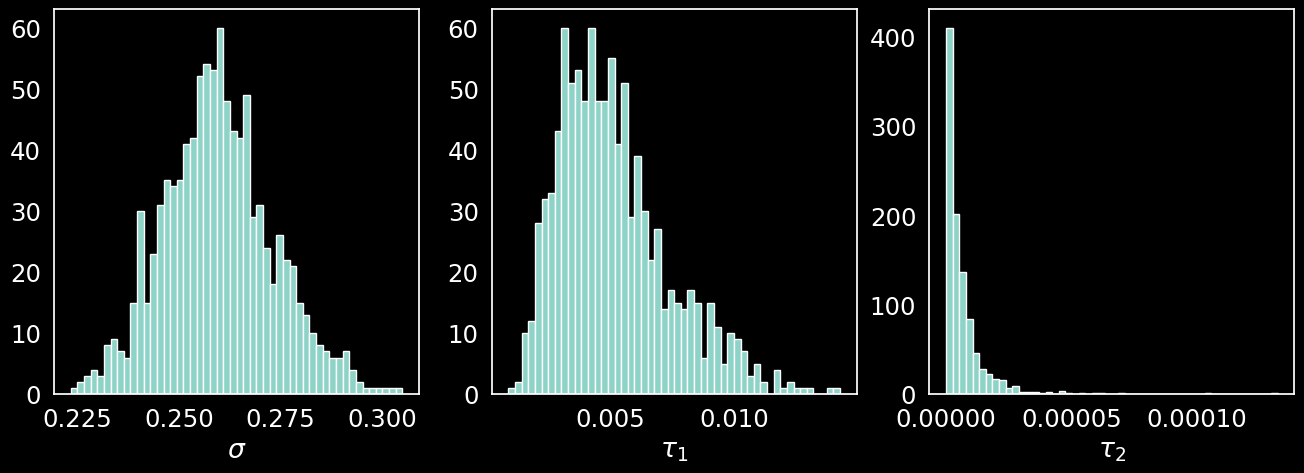

In [22]:
# posterior distribution for other model parameters
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].hist(np.array(samples['sigma']), bins=50);
axes[0].set_xlabel(r'$\sigma$')
axes[1].hist(np.array(samples['tau1']), bins=50);
axes[1].set_xlabel(r'$\tau_1$')
axes[2].hist(np.array(samples['tau2']), bins=50);
axes[2].set_xlabel(r'$\tau_2$');

In [29]:
 # compute the mean and square root variance of each coefficient theta_i
means, stds = vmap(lambda dim: analyze_dimension(samples, X, Y1_pair, dim, c=c))(
    jnp.arange(D)
)

print(
    "Coefficients theta_1 to theta_%d used to generate the data:"
    % S,
    expected_thetas1_pair
)
print(
    "The single quadratic coefficient theta_{1,2} used to generate the data:",
    expected_pairwise1,
)

Coefficients theta_1 to theta_5 used to generate the data: [0.4465585  0.47040176 0.23218709 0.2950355  0.5207558 ]
The single quadratic coefficient theta_{1,2} used to generate the data: 0.21967684


In [30]:
act_dimensions = []

for dim, (mean, std) in enumerate(zip(means, stds)):
    # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
    lower, upper = mean - 3.0 * std, mean + 3.0 * std
    inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
    if inactive == "active":
        act_dimensions.append(dim)
    print(
        "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
        % (dim + 1, D, inactive, mean, std)
    )

print(
    "Identified a total of %d active dimensions; expected %d."
    % (len(act_dimensions), S)
)

[dimension 01/50]  active:	4.62e-01 +- nan
[dimension 02/50]  active:	4.62e-01 +- nan
[dimension 03/50]  active:	1.96e-01 +- 2.20e-02
[dimension 04/50]  active:	2.99e-01 +- 2.17e-02
[dimension 05/50]  active:	5.09e-01 +- 2.00e-02
[dimension 06/50]  inactive:	7.14e-04 +- 9.88e-03
[dimension 07/50]  inactive:	1.19e-03 +- 9.95e-03
[dimension 08/50]  inactive:	7.90e-03 +- 1.57e-02
[dimension 09/50]  inactive:	-3.63e-03 +- 1.14e-02
[dimension 10/50]  inactive:	-4.64e-04 +- 1.01e-02
[dimension 11/50]  inactive:	-3.38e-03 +- 1.16e-02
[dimension 12/50]  inactive:	-6.39e-04 +- 1.01e-02
[dimension 13/50]  inactive:	1.71e-03 +- 1.04e-02
[dimension 14/50]  inactive:	1.37e-03 +- 1.02e-02
[dimension 15/50]  inactive:	-7.47e-04 +- 9.67e-03
[dimension 16/50]  inactive:	-2.17e-03 +- 1.07e-02
[dimension 17/50]  inactive:	-2.99e-03 +- 1.12e-02
[dimension 18/50]  inactive:	3.32e-03 +- 1.19e-02
[dimension 19/50]  inactive:	-7.43e-04 +- 1.03e-02
[dimension 20/50]  inactive:	-2.67e-03 +- 1.12e-02
[dimension 

In [31]:
# Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
# Note that the resulting numbers are only meaningful for i != j.
if len(act_dimensions) > 0:
    dim_pairs = jnp.array(
        list(itertools.product(act_dimensions, act_dimensions))
    )
    means, stds = vmap(
        lambda dim_pair: analyze_pair_of_dimensions(
            samples, X, Y1_pair, dim_pair[0], dim_pair[1], c=c
        )
    )(dim_pairs)
    for dim_pair, mean, std in zip(dim_pairs, means, stds):
        dim1, dim2 = dim_pair
        if dim1 >= dim2:
            continue
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        if not (lower < 0.0 and upper > 0.0):
            format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
            print(format_str % (dim1 + 1, dim2 + 1, mean, std))
    # Draw a single sample of coefficients theta from the posterior, where we return all singleton
    # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
    # final MCMC sample obtained from the HMC sampler.
    thetas = sample_theta_space(
        X,
        Y1_pair,
        act_dimensions,
        samples["lam"][-1],
        samples["tau1"][-1],
        samples["tau2"][-1],
        samples["sigma"][-1],
        c
    )
    print("Single posterior sample theta:\n", thetas)

Identified pairwise interaction between dimensions 1 and 2: 2.11e-01 +- 1.83e-02
Single posterior sample theta:
 [ 4.31291342e-01  4.82844800e-01  1.91661105e-01  2.97066033e-01
  5.18977404e-01 -3.40377912e-03  1.16221793e-02 -1.34829776e-02
 -3.21591459e-03  3.45905451e-03  2.61458801e-03  4.80521144e-03
 -7.21931318e-03 -8.59221630e-03  2.11876165e-03  9.54547524e-03
 -7.56084919e-03 -1.23424139e-02 -1.44734338e-03  6.33056741e-04
  9.68214683e-03  8.42040870e-03  3.01185576e-03 -6.34723250e-03
  2.15037889e-03 -1.17699914e-02 -2.90271547e-03 -6.28717896e-03
 -1.01061305e-02 -5.86035103e-03 -1.00320333e-03  3.69463395e-03
  8.46201181e-03  5.64930215e-03 -1.43554583e-02 -8.52343999e-03
 -1.47585291e-02  8.36579688e-03  1.10646188e-02 -7.46058207e-03
 -8.63548182e-03 -3.27029754e-03 -1.27416728e-02  2.76252162e-03
  5.07780258e-03 -3.59471119e-03  2.35356726e-02 -8.58611241e-03
  5.47802495e-03 -2.67826188e-02  2.24470764e-01  2.96068620e-02
 -1.12029249e-02 -1.04052722e-02 -2.639232

Finally we can do the same analysis in the case of correlated predictors.

In [32]:
%%time
nuts = NUTS(skim)
mcmc = MCMC(nuts, num_warmup=1000, num_samples=1000)
mcmc.run(random.PRNGKey(101010), X_corr, Y=Y2_pair, p0=S, c=c)

samples = mcmc.get_samples()

sample: 100%|██████████| 2000/2000 [02:34<00:00, 12.91it/s, 15 steps of size 1.91e-01. acc. prob=0.93]

CPU times: user 15min 7s, sys: 1h 4min 23s, total: 1h 19min 30s
Wall time: 2min 35s


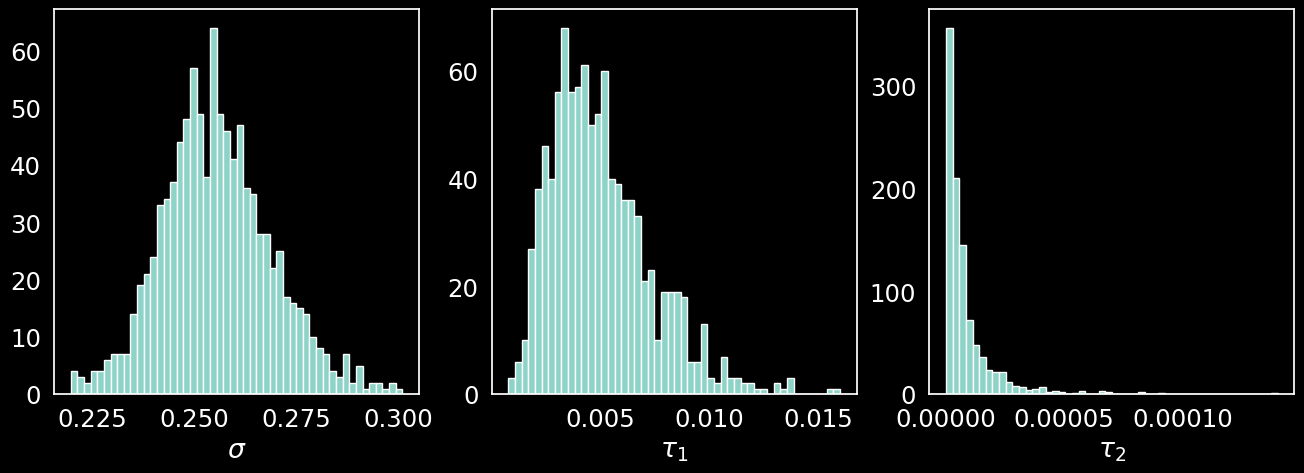

In [33]:
# posterior distribution for other model parameters
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].hist(np.array(samples['sigma']), bins=50);
axes[0].set_xlabel(r'$\sigma$')
axes[1].hist(np.array(samples['tau1']), bins=50);
axes[1].set_xlabel(r'$\tau_1$')
axes[2].hist(np.array(samples['tau2']), bins=50);
axes[2].set_xlabel(r'$\tau_2$');

In [34]:
 # compute the mean and square root variance of each coefficient theta_i
means, stds = vmap(lambda dim: analyze_dimension(samples, X_corr, Y2_pair, dim, c=c))(
    jnp.arange(D)
)

print(
    "Coefficients theta_1 to theta_%d used to generate the data:"
    % S,
    expected_thetas2_pair
)
print(
    "The single quadratic coefficient theta_{1,2} used to generate the data:",
    expected_pairwise2,
)

Coefficients theta_1 to theta_5 used to generate the data: [0.4352283  0.4584666  0.22629598 0.2875498  0.507543  ]
The single quadratic coefficient theta_{1,2} used to generate the data: 0.21410313


In [35]:
act_dimensions = []

for dim, (mean, std) in enumerate(zip(means, stds)):
    # we mark the dimension as inactive if the interval [mean - 3 * std, mean + 3 * std] contains zero
    lower, upper = mean - 3.0 * std, mean + 3.0 * std
    inactive = "inactive" if lower < 0.0 and upper > 0.0 else "active"
    if inactive == "active":
        act_dimensions.append(dim)
    print(
        "[dimension %02d/%02d]  %s:\t%.2e +- %.2e"
        % (dim + 1, D, inactive, mean, std)
    )

print(
    "Identified a total of %d active dimensions; expected %d."
    % (len(act_dimensions), S)
)

[dimension 01/50]  active:	4.54e-01 +- nan
[dimension 02/50]  active:	4.60e-01 +- 2.65e-02
[dimension 03/50]  active:	2.15e-01 +- 2.13e-02
[dimension 04/50]  active:	2.80e-01 +- 2.19e-02
[dimension 05/50]  active:	4.83e-01 +- 2.07e-02
[dimension 06/50]  inactive:	2.21e-03 +- 1.08e-02
[dimension 07/50]  inactive:	-1.46e-03 +- 1.01e-02
[dimension 08/50]  inactive:	4.11e-03 +- 1.25e-02
[dimension 09/50]  inactive:	-3.37e-03 +- 1.16e-02
[dimension 10/50]  inactive:	-1.01e-04 +- 1.01e-02
[dimension 11/50]  inactive:	-8.28e-04 +- 1.03e-02
[dimension 12/50]  inactive:	1.61e-03 +- 1.05e-02
[dimension 13/50]  inactive:	2.84e-03 +- 1.12e-02
[dimension 14/50]  inactive:	-1.71e-04 +- 1.01e-02
[dimension 15/50]  inactive:	-8.51e-05 +- 9.79e-03
[dimension 16/50]  inactive:	-1.63e-03 +- 1.03e-02
[dimension 17/50]  inactive:	-6.71e-04 +- 1.00e-02
[dimension 18/50]  inactive:	1.02e-03 +- 1.01e-02
[dimension 19/50]  inactive:	-1.18e-03 +- 1.05e-02
[dimension 20/50]  inactive:	-4.65e-04 +- 9.80e-03
[dime

In [36]:
# Compute the mean and square root variance of coefficients theta_ij for i,j active dimensions.
# Note that the resulting numbers are only meaningful for i != j.
if len(act_dimensions) > 0:
    dim_pairs = jnp.array(
        list(itertools.product(act_dimensions, act_dimensions))
    )
    means, stds = vmap(
        lambda dim_pair: analyze_pair_of_dimensions(
            samples, X_corr, Y2_pair, dim_pair[0], dim_pair[1], c=c
        )
    )(dim_pairs)
    for dim_pair, mean, std in zip(dim_pairs, means, stds):
        dim1, dim2 = dim_pair
        if dim1 >= dim2:
            continue
        lower, upper = mean - 3.0 * std, mean + 3.0 * std
        if not (lower < 0.0 and upper > 0.0):
            format_str = "Identified pairwise interaction between dimensions %d and %d: %.2e +- %.2e"
            print(format_str % (dim1 + 1, dim2 + 1, mean, std))
    # Draw a single sample of coefficients theta from the posterior, where we return all singleton
    # coefficients theta_i and pairwise coefficients theta_ij for i, j active dimensions. We use the
    # final MCMC sample obtained from the HMC sampler.
    thetas = sample_theta_space(
        X_corr,
        Y2_pair,
        act_dimensions,
        samples["lam"][-1],
        samples["tau1"][-1],
        samples["tau2"][-1],
        samples["sigma"][-1],
        c
    )
    print("Single posterior sample theta:\n", thetas)

Identified pairwise interaction between dimensions 1 and 2: 2.10e-01 +- 2.18e-02
Single posterior sample theta:
 [ 4.88609940e-01  4.85405892e-01  2.20569998e-01  2.89577812e-01
  4.70331252e-01 -1.13516673e-03  4.97485837e-03 -8.25572386e-03
  2.33499706e-02 -1.95877859e-03 -1.75408029e-04  1.90086029e-02
 -2.35365354e-03 -1.12454323e-02  8.06584023e-03  1.38613721e-03
 -1.60289835e-03  1.55741153e-02 -1.68447755e-02 -1.02071662e-03
 -1.99413635e-02 -1.33666843e-02 -1.36381369e-02 -2.06319056e-03
  2.09166249e-03 -4.74316999e-03  8.61212611e-03 -1.95092685e-03
  5.91910258e-03 -9.55323782e-03 -1.31157716e-03  2.04221997e-02
  4.73883050e-03 -1.74329034e-03  2.92676385e-04 -1.26004899e-02
  9.62772127e-03  9.75216331e-04  1.10282912e-03  8.39987420e-04
 -2.00856151e-03 -4.99168225e-03 -7.23614078e-03  3.10621038e-03
  4.16726572e-03  1.96144469e-02  3.94768920e-03 -1.18992645e-02
  3.20768403e-03  2.69599212e-03  2.40232348e-01  2.83430591e-02
 -2.50321310e-02 -1.27440430e-02  2.494125

Importantly, SKIM performs equally well on data sets generated both with independent and correlated predictors.